last updated 11 03 24

This notebook is to get the run times for each model on the highest and lowest resolutions; to estimate an average run time.IG DICITONARY!



In [1]:
#!pip install ipython

In [2]:
# imports
import torch
import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

from functions import import_imagedata, ImageProcessor, label_oh_tf
from fns4wandb import  set_lossfn
from architectures import sevennet, smallnet1, smallnet2, smallnet3
from loop_fns import loop
from plotting import learning_curve, accuracy_curve, plot_confusion

from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
import time

import csv
import json
import pickle
import os

import wandb

In [3]:
# file paths
_save_location = r'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/'

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = '5b835027b98560be2802b81891d000be97a6c8bc'

In [4]:
wandb.login()

wandb: Currently logged in as: naughticalnonsence (antvis). Use `wandb login --relogin` to force relogin


True

In [5]:
#!pip install datetime

d = date.today()
#print(str(d), type(str(d)))

452 144               5/452 *100 = 1%
226 72                5/226 *100 = 2%
113 36                5/113 *100 = 4% -- 2/113 *100= 1.7% ~ 2%
57  18   (56.5,)      5/57 *100  = 8% -- 2/57 *100 = 3.5% ~ 4%.   1/57 = 1.75%
29   9   (28.5,)      5/29 *100  = 17% -- 2/29 *100 = 6.89 ~ 7%   1/28 = 3.57 ~ 4%
15   5   (14.5, 4.5)
8    3   (7.5,2.5)
4,   2   (, 1.5)

In [6]:
   

pp = pprint.PrettyPrinter(indent=4)

def save2csv_nest_dict(nested_dict, file_name, save_location:str):
  # flattern nested dictionary
  flatterend_dict = {}
  for k,v in nested_dict.items():
    if isinstance(v, dict):
      for nested_key, nested_val in v.items():
        flatterend_dict[f"{k}_{nested_key}"] = nested_val
    else:
      flatterend_dict[k] =v

  columns = list(flatterend_dict.keys())

  with open(save_location+str(file_name)+'.csv', "a+", newline="") as f:
      # using dictwriter
      writer = csv.DictWriter(f, fieldnames=columns)
      # using writeheader function
      if f.tell() == 0:
        writer.writeheader()
      writer.writerow(flatterend_dict)
      f.close()

# check dictionary values for json and csv

def check_obj4np(obj):
    if isinstance(obj, dict):
        return {key: check_obj4np(value) for key, value in obj.items()}
    if isinstance(obj,list):
        return [check_obj4np(item) for item in obj]
    if isinstance(obj,np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    else:
        return obj

# save to json
def save2josn_nested_dict(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    json_obj = json.dumps(nested_dict, indent=4)
    with open(save_location+str(file_name)+'.json', 'a+') as f:
        f.write(json_obj)
        f.close()

    
#save_location+str(file_name)+'.csv'
def save2csv(nested_dict, file_name, save_location:str):
    
    nested_dict = check_obj4np(nested_dict)
    
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])
        

def save2json(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    #print(nested_dict)
    #print(nested_dict.items())
    json_obj = json.dumps(nested_dict, indent=4)
    #print(json_obj)
    path = os.path.join(save_location, file_name+".json")
    #print(path)
    with open(path, 'w') as f:
        f.write(json_obj)
        
        


def read_in_json(file_path, file_name):
    path = os.path.join(file_path, 'file_name')
    try:
        with open(path, 'r') as f:
            #obj = f.read()
            dj = json.load(f, object_pairs_hook= collections.OrderedDict) #obj, 
            #print(dj)
    except Exception as e:
        print("Error decoding Json")
        print(e)


class Flattern(nn.Module):
    def __init__(self):
        super(Flattern, self).__init__()
    def forward(self, x):
        #print(x.shape)
        x = x.flatten()
        return x


def choose_model(model_name, lin_lay, dropout):

    #for model_card in config.model_cards:
    #print('\n choose_model \n MODEL NAME: ',model_name)

    if model_name == '4c3l':
        return smallnet1(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '3c2l':
        return smallnet2(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks = (3,5), dropout=dropout)
    elif model_name == '2c2l':
        return smallnet3(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '7c3l':
        return sevennet(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == 'vgg16':
        model_vgg16 = vgg16(weights="IMAGENET1K_V1")
        vgg_feats = model_vgg16.features
        vgg_classifier = model_vgg16.classifier
        vgg_classifier.pop(6)

        vgg = nn.Sequential(
            vgg_feats,
            Flattern(),
            vgg_classifier,
            nn.Linear(4096,11),
            nn.Softmax(dim=0),
            )
        return vgg
    else:
        print('Model Name Not Recognised')


In [7]:
# dictionaries

date = date.today()

model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                            ],
                 'idx': 0,
                 'dropout':0.2}


model_card_7c3l = {'name': '7c3l', 'model': '7c3l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[248832,    # 452 144    # p5
                            59904,      # 226 72     # p5
                            11264,      # 113  36    # p2
                            1536,       # 57 18      # p1
                            172032,           # 29  9
                            172032,          # 15 5
                            172032,         # 8 3
                              ], 
                   'idx': 1,
                  'dropout':0.2}



model_card_4c3l = {'name': '4c3l', 'model': '4c3l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[539904,    # 452 144    # p5
                             141056,    # 226 72     # p5
                             304640,     # 113  36    # p2
                             9984,      # 57 18      # p1
                             2304,      # 29  9
                             512,       # 15 5
                             256],      # 8 3
                  'idx': 2,
                  'dropout':0.2}      

model_card_3c2l = {'name': '3c2l', 'model': '3c2l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[1069888,    # 452 144    # p5
                             274688,     #226 72      # p5
                             68096,      # 113  36    # p2
                             17280,      # 57 18      # p1
                             3840,       # 29  9
                             960,        # 15 5
                             256],
                  'idx': 3,
                  'dropout':0.2}       # 8 3

model_card_2c2l = {'name': '2c2l', 'model': '2c2l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[1055232,    # 452 144    # p5
                             267264,     #226 72      # p5
                             64512,      # 113  36    # p2
                             15552,      # 57 18      # p1
                             3072,       # 29  9
                             640,        # 15 5
                             128],
                  'idx': 4,
                  'dropout':0.1}       # 8 3

resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



#resolution_cards = [resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,
#                    resolution_card_299, resolution_card_155, resolution_card_83]
resolution_cards = [resolution_card_11336]

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards =  [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [0.0001]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
scheduler_cards = [0]

seeds = [8,2,3] # 4, 5,6

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_2c2l]

loss_fn_cards = ['CrossEntropy'] #'MSE', 
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler_cards':scheduler_cards})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


#print(model_card_vgg)
#print('')
#pp.pprint(config) # dictionary of dictionaries of lists and lists of dictionaries

In [8]:

def train_model(model, x_train, x_val, y_train, y_val, res, pad, save_dict, lr, optimizer, scheduler_value, loss_fn, epochs, model_name, av_lum): #train_dl, val_dl, 


    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)#build_optimizer(mo
    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value, last_epoch=-1) 
    #scheduler'
    ####
    
    #model = model.to(device)
    model.train()
    
    
    #losses= []
    #predictions = []
    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []

    
    total_epochs = 0
    for epoch in tqdm(range(epochs)):

        print('Training...')
    
        t_loss, train_prediction, t_correct, model, optimizer = loop(model=model, X=x_train, Y=y_train, loss_fn=loss_fn, device=device, 
                                                                     size= res,  pad=pad, num_classes=11, model_name= model_name, av_lum=av_lum,
                                                                     optimizer=optimizer) #, scheduler =scheduler
        
        t_loss_list.append(t_loss)
        t_predict_list.append(train_prediction)
        wandb.log({'t_loss':t_loss})
        #wandb.log({'t_predict_list':train_prediction})
        #wandb.log({'train_labels':list(y_train)})
        train_acc = (t_correct/len(x_train)*100)
        print('train accuracy: ', train_acc )
        t_accuracy_list.append(train_acc)
        wandb.log({'train_acc':train_acc})
        #y_train_save = y_train.tolist()

        
        #clear_output()
        
            
        print('validating...')
        
        v_loss, val_prediction, val_correct= loop(model=model, X=x_val, Y=y_val, loss_fn=loss_fn, device=device,
                                                  size= res,  pad=pad, num_classes=11, model_name= model_name, 
                                                  av_lum=av_lum, train=False)

        v_loss_list.append(v_loss)
        v_predict_list.append(val_prediction)
        wandb.log({'v_loss':v_loss})
        #wandb.log({'v_predict_list':val_prediction})
        #wandb.log({'y_val':list(y_val)})
        val_acc = (val_correct/len(x_val)*100)
        v_accuracy_list.append(val_acc)
        print('validation accuracy: ', val_acc )
        wandb.log({'val_acc':val_acc})

        #clear_output()
            
        total_epochs += 1
        
    save_dict['Current_Epoch'] = epochs
    save_dict['training_samples'] = len(x_train)
    save_dict['validation_samples'] = len(x_val)

    save_dict['t_accuracy_list'] = t_accuracy_list 
    save_dict['v_accuracy_list'] = v_accuracy_list  #
            
    #model = best_model
    save_dict['t_loss_list'] = t_loss_list
    save_dict['v_loss_list'] = v_loss_list
    
    save_dict['t_labels'] = y_train
    save_dict['v_labels'] = y_val
    
    save_dict['t_predict_list'] = t_predict_list 
    save_dict['v_predict_list'] = v_predict_list  #
    
    #wandb.log({'y_train':y_train})
    #wandb.log({'t_predict_list':t_predict_list})

    #wandb.log({'t_accuracy_list':t_accuracy_list})

    #y_val_save = y_val.tolist()
    
    
    #

    
    #wandb.log({'v_accuracy_list':v_accuracy_list})

    return model, save_dict

def test_loop(model, model_name, X, Y, res, pad, save_dict, loss_fn, device, av_lum, num_classes=11):
    model = model.eval()
    predict_list = []
    current_loss = 0
    total_count =0
    num_correct = 0
    correct = 0
    colour ='colour'
    size =  res

    with torch.no_grad():
        print('Testing...') 
        for idx, img in enumerate(X):

            #image pre processing
            prepro = ImageProcessor(device)
            if model_name == 'vgg16':
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True) #[29, 9], 15, 5, [8,3]
            elif (model_name == '7c3l' and size == [29, 9]) or (model_name == '7c3l' and size == [15, 5]) or (model_name == '7c3l' and size ==[8, 3]):
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True)
            else:
                tense = prepro.colour_size_tense(img, colour, size,av_lum,  pad)

            # send through model
            prediction = model.forward(tense)
            label = label_oh_tf(Y[idx], num_classes).to(device)
            loss = loss_fn(prediction, label)

            if prediction.argmax()==label.argmax():
                num_correct +=1
            total_count +=1
            correct +=(prediction.argmax()==label.argmax()).sum().item()

            predict_list.append(prediction.argmax())

        acc = num_correct/total_count
        accuracy = 100*(acc)
        
        
        
        current_loss += loss.item()
        
    return accuracy, predict_list, Y, current_loss


def get_data(random_seed):
    file_path =  data_path
    #print(file_path)
    img_len = len(os.listdir(file_path))
    
    x, y = import_imagedata(file_path)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)

    return x_train, y_train, x_val, y_val, x_test, y_test


    
def get_lin_lay(model_card, resolution):
    if resolution == [452, 144]:
        lin_lay = model_card['f_lin_lay'][0]
    elif resolution == [226, 72]:
        lin_lay = model_card['f_lin_lay'][1]
    elif resolution == [113, 36]:
        lin_lay = model_card['f_lin_lay'][2]
    elif resolution == [57, 18]:
        lin_lay = model_card['f_lin_lay'][3]
    elif resolution == [29, 9]:
        lin_lay = model_card['f_lin_lay'][4]
    elif resolution == [15, 5]:
        lin_lay = model_card['f_lin_lay'][5]
    elif resolution == [8, 3]:
        lin_lay = model_card['f_lin_lay'][6]
    else:
        print("PARAMETER NOT FOUND: \n f_lin_lay FROM MODEL CARD")
    return lin_lay


In [15]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"


def _go(config=None):
    
    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        print('Git Hash registered')
        
    with wandb.init(config=config, project=f"test 2 Run Big Loop", notes="First logging test of big loop. limitied data",):
        config = wandb.config
        start = time.process_time()
    
        for model_idx, model_card in enumerate(config['model_cards']):
            
            model_name = model_card['model']
            model_index = model_card['idx']
            dropout = model_card['dropout'] 
            
            
            for res_idx, resolution_card in enumerate(config['resolution_cards']):
    
                resolution = resolution_card['resolution']
                pad = resolution_card['padding']
               
                lin_lay = get_lin_lay(model_card, resolution)
    
                
                for lr_idx, lr in enumerate(config['learning_rate_cards']):
                    for wd_idx, wd_card in enumerate(wd_cards):
                        for sched_idx, scheduler_value in enumerate(config['scheduler_cards']):
                            for seed_idx, seed in enumerate(config['seeds']):
                                seed = seed
                                for lossfn_idx, lossfn in enumerate(config['loss_fn_cards']):
                                    
                                    
                                    #print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    #print(config.model_cards, len(config.model_cards), type(config.model_cards))
                                    print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    print('resolution: ', str(resolution), f"  idx: {res_idx} / {len(config['resolution_cards'])}")
                                    print('learning rate: ', str(lr), f"  idx: {lr_idx} / {len(config['learning_rate_cards'])}")
                                    print('weight decay: ', str(wd_card), f"  idx: {wd_idx} / {len(config['wd_cards'])}")
                                    print('scheduler: ', str(scheduler_value), f"  idx: {sched_idx} / {len(config['scheduler_cards'])}")
                                    print('seed: ', str(seed), f"  idx:  {seed_idx} / {len(config['seeds'])}")
                                    print('loss function: ', str(lossfn), f" idx: {lossfn_idx} / {len(config['loss_fn_cards'])}")
                                    run_start_time = time.process_time()
                                    print(run_start_time)
   
                                    print(time.process_time() - start)
                                    
        
                                    epochs = 40 #40

                                    IP = ImageProcessor(device)

                                    print(f"Total epochs: {epochs}")
                                     
                                    wandb.log({'gitHash':gitHASH})
                                    wandb.log({'Epochs': epochs})
                                    # set save dictionary
                                    save_dict = {'Run' : f"{model_name}{resolution}{date}",
                                                 'Current_Epoch': 0,
                                                 'save_location' : _save_location}
                                    
                                    # set model
                                    model = choose_model(model_name, lin_lay, dropout).to(device)
                                    #print(model, '\n', type(config))
                                    # get image data
                                    x_train, y_train, x_val, y_val, x_test, y_test = get_data(seed)
                                    av_lum = IP.new_luminance(x_train)
                                    
                                    # set loss function
                                    loss_fn = set_lossfn(lossfn)
                                    
                                    # set optimizer
                                    optimizer = torch.optim.Adam(model.parameters(),lr=lr)

                                    
                                    wandb.watch(model, loss_fn, log='all', log_freq=2, idx = model_index)
                                    model, save_dict=  train_model(model, x_train, x_val, y_train, y_val, resolution, pad, save_dict, lr,optimizer,
                                                                   scheduler_value, loss_fn,epochs,
                                                                   model_name, av_lum)

                                    #test                                               Y,          
                                    test_acc,test_predict_list, y_test, test_loss = test_loop(model, model_name, x_test, y_test,resolution, pad, save_dict,loss_fn,
                                                                                              device, av_lum, num_classes=11) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
                                    
                                    #print(test_predict_list)
                                    print(' \n train acc: ', save_dict['t_accuracy_list'][-1])
                                    print(' \n val acc: ', save_dict['v_accuracy_list'][-1])
                                    print(' \n test acc: ', test_acc)
                                    
                                    save_dict.update({'test_acc': test_acc})
                                    save_dict.update({'test_predict': test_predict_list})
                                    save_dict.update({'test_labels': list(y_test)})
                                    save_dict.update({'test_loss':test_loss})


                                    learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=save_dict['Run'])
                                    accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=save_dict['Run'])
                                    test_predict_list=[pred.cpu() for pred in test_predict_list]
                                    plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = save_dict['Run'],save_location =save_dict['save_location'])
                                    
                                    wandb.log({'test_acc': test_acc})
                                    wandb.log({'test_predict': test_predict_list})
                                    wandb.log({'test_labels': list(y_test)})
                                    #saving
                                    diction = {}
                                    d = date.today()
                                    d=str(d)
                                    diction.update({'Date':d})
                                    diction.update({'gitHASH':str(gitHASH)})
                                    diction.update({'model_name': str(model_name)})
                                    diction.update({'loss_fn': str(lossfn)})
                                    diction.update({'lr': str(lr)})
                                    diction.update({'wd': str(wd_card)})
                                    diction.update({'scheduler value': str(scheduler_value)})
                                    diction.update({'seed': str(seed)})
                                    diction.update({'resolution': str(resolution)})
                                    diction.update({'pad': int(pad)})
                                    diction.update({'lin_lay': int(lin_lay)})
                                    diction.update({'run time': (time.process_time() - run_start_time)})
                                    diction.update(save_dict)
                                    
                                    save_location = save_dict['save_location']
                                    title = save_dict['Run']
                                    save2json(diction, title, save_location)
                                    save2csv(diction, title, save_location)
        
                                    diction['model.state_dict'] = model.state_dict() #to('cpu').
        
                                    with open(f"{save_location}{title}.pkl", 'wb+') as f:
                                        pickle.dump(diction, f)
                                    
                                    #clear_output()
                                    
                                    print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)

        print('Final Run time:  ',time.process_time() - start)

Git Hash registered


Model:  2c2l  idx: 0 / 1
[{'name': '2c2l', 'model': '2c2l', 'channels': 3, 'ks': [3, 5], 'f_lin_lay': [1055232, 267264, 64512, 15552, 3072, 640, 128], 'idx': 4, 'dropout': 0.1}] 1 <class 'list'>
Model:  2c2l  idx: 0 / 1
resolution:  [113, 36]   idx: 0 / 1
learning rate:  0.0001   idx: 0 / 1
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 1
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
87.393875661
0.04710513700000263
Total epochs: 3


  0%|                                 | 0/3 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.804283164782866
validating...


 33%|████████▎                | 1/3 [00:06<00:12,  6.20s/it]

validation accuracy:  10.818307905686545
Training...
train accuracy:  11.124330755502678
validating...


 67%|████████████████▋        | 2/3 [00:12<00:06,  6.29s/it]

validation accuracy:  19.27877947295423
Training...
train accuracy:  20.82093991671624
validating...


100%|█████████████████████████| 3/3 [00:18<00:00,  6.27s/it]

validation accuracy:  25.381414701803052
Testing...


 
 train acc:  20.82093991671624
 
 val acc:  25.381414701803052
 
 test acc:  22.62135922330097


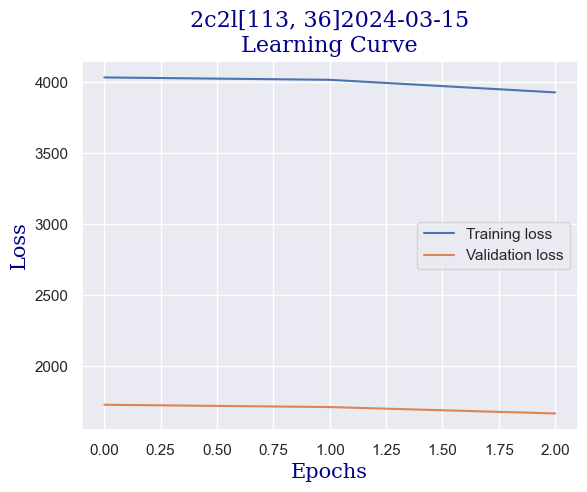

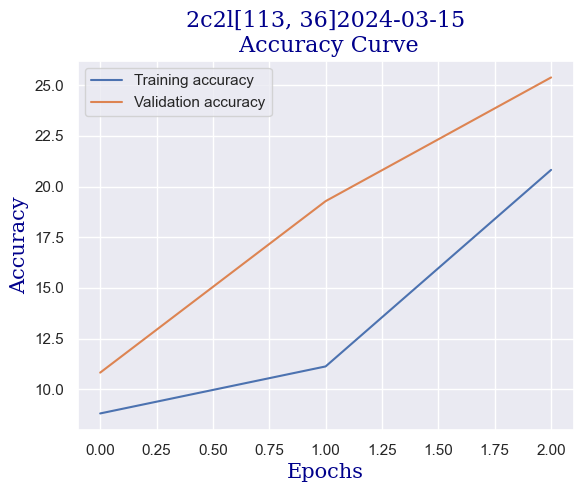

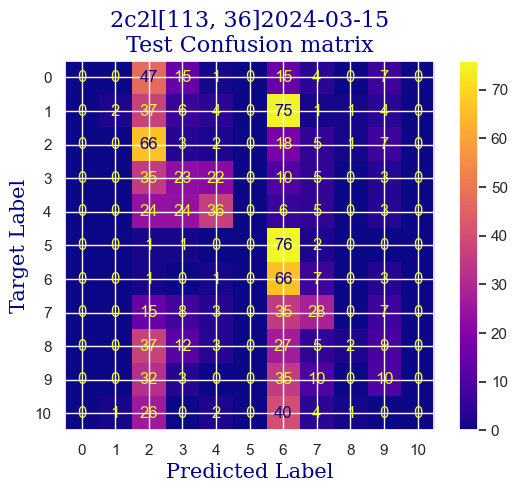

 
 END 2c2l [113, 36] Run Time:  22.925373140000005


Epochs,▁
t_loss,█▇▁
test_acc,▁
train_acc,▁▂█
v_loss,█▆▁
val_acc,▁▅█
Epochs,3
gitHash,5b835027b98560be2802...
t_loss,3927.36491
test_acc,22.62136
train_acc,20.82094


Traceback (most recent call last):
  File "/its/home/nn268/.local/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 162, in __getattr__
    return self.__getitem__(key)
  File "/its/home/nn268/.local/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'model_cards'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_135680/817045240.py", line 39, in _go
    print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
  File "/its/home/nn268/.local/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 164, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'model_cards'


AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'model_cards'

In [16]:
_go(config)